## SolarForecast - Hypertuning of energy model
Inspired by https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
# load libraries and dataset

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# load dataset
cnx = create_engine('mysql+pymysql://<<dbuser>>:<<password>>@<<hostname>>:<<port>>/fhem', echo=False)
query = "select EnergyHour, Month, Brightness, SunAlt, SunAz, Temp from SolarEnergyFc order by Year, Month, Day, Hour"

features = ['Brightness', 'SunAlt', 'SunAz', 'Temp']

# Using a context manager for safe resource handling
with cnx.connect() as conn:
  result = conn.execute(text(query))
  columns = result.keys() # Extract column names
  data = pd.DataFrame(result.fetchall(), columns=columns)

#ignore the last 40 record, because contain weather condition forecasts
data = data[:-40]

#map month to seassons
month_seasson_mapping = {
    1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3, 9:2, 10:2, 11:1, 12:1
}
data["Seasson"] = data["Month"].map(lambda x: month_seasson_mapping[x])

categorical_features = pd.get_dummies(data, columns = ['Seasson'])

X = pd.concat([categorical_features], axis=1)
X = X.drop(['EnergyHour','Month'],axis=1)

y = data['EnergyHour'].values.copy()

# split whole days only (20 records are one day)
test_size = int(len(X)*0.25/20)*20/len(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = test_size,shuffle=False)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X.head(20)

(4480, 7) (1480, 7) (4480,) (1480,)


,Brightness,SunAlt,SunAz,Temp,Seasson_1,Seasson_2,Seasson_3
0,0,0.0,0.0,0.0,True,False,False
1,0,0.0,0.0,0.0,True,False,False
2,0,0.0,0.0,0.0,True,False,False
3,0,0.0,0.0,0.0,True,False,False
4,6470,1.3,128.4,6.6,True,False,False
5,4705,10.1,140.2,6.6,True,False,False
6,17647,17.5,153.1,8.0,True,False,False
7,8823,23.6,167.3,8.0,True,False,False
8,8823,27.7,177.0,8.0,True,False,False
9,20000,29.1,160.3,8.9,True,False,False


In [29]:
# Define ranges to find the best parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 25, 30, 35]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
 
 
model = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = model,
                                   param_distributions = grid_params,
                                   n_iter = 100,
                                   cv = 4, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -1)    

rf_random.fit(X_train,y_train)

print(rf_random.best_params_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
{'n_estimators': 1788, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.6, 'max_depth': 100, 'bootstrap': False}


In [30]:
# fit and predict models

base_model = RandomForestRegressor(random_state = 42)
base_model.fit(X_train,y_train)

y_pred_base = base_model.predict(X_test)
r2_score_base = metrics.r2_score(y_test, y_pred_base)

best_model = rf_random.best_estimator_
best_model.fit(X_train,y_train)

y_pred_best = best_model.predict(X_test)
r2_score_best = metrics.r2_score(y_test, y_pred_best)

print('Base R^2 score: %.4f' % r2_score_base)
print('Best R^2 score: %.4f' % r2_score_best)
print("----------------------")
print('Improvement: {:0.2f} %'.format( 100 * (r2_score_best - r2_score_base) / r2_score_base))

print("======================")
print("Feature importance:")
print("----------------------")
# Get numerical feature importances
importances = list(best_model.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Base R^2 score: 0.8716
Best R^2 score: 0.9479
----------------------
Improvement: 8.75 %
Feature importance:
----------------------
Variable: Brightness           Importance: 0.65
Variable: SunAlt               Importance: 0.21
Variable: SunAz                Importance: 0.11
Variable: Temp                 Importance: 0.03


[None, None, None, None]

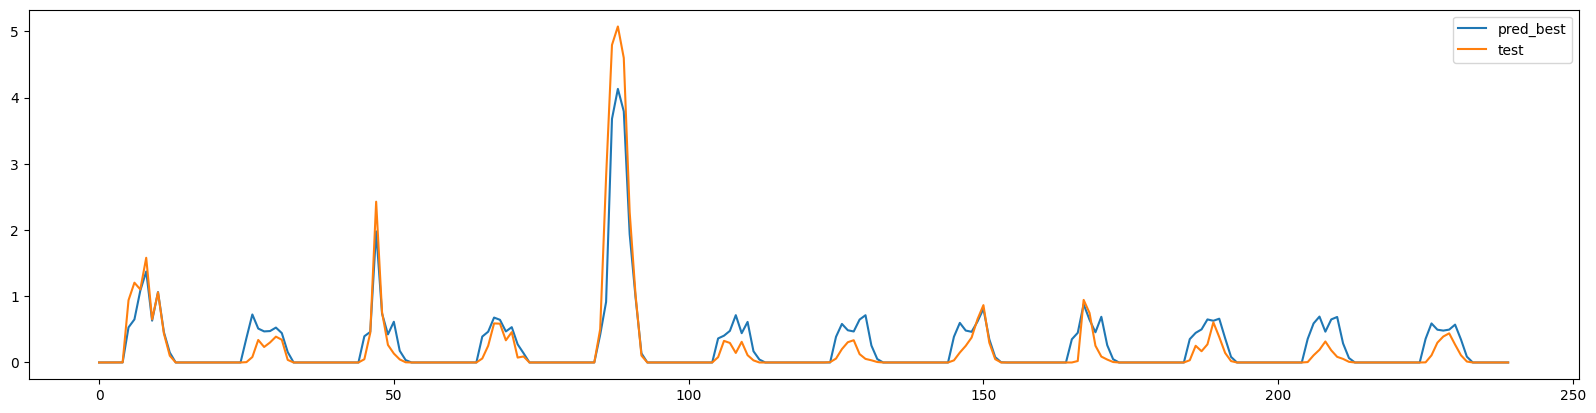

In [31]:
# plot comparision test vs. predicted values
plt.figure().set_figwidth(20)
plt.plot(y_pred_best[-240:], label='pred_best')
plt.plot(y_test[-240:], label='test')
plt.legend()
plt.show()